### Aihemallinnusta: suomenkielisen demoskene-Wikipedia-sivun mallintaminen aiheisiin

Tmtoolkit-kirjasto tarvitsee toimiakseen lda-kirjaston kanssa Python-version 3.8-3.10.

Toteutuksessa aiheiden määrän määrittämiseen on käytetty tmtoolkit-kirjaston coherence_mimno_2011-metriikkaa.
Toteutusta varten kirjasto asennetaan seuraavasti:

pip install -U "tmtoolkit[recommended,lda]"

Huomaa, että yo. ei asenna lda-kirjastoa, joka on asennettava erikseen:

pip install -U lda

Tarvitaan myös spaCy:

pip install -U spacy

Käytetty NLP-malli ladataan komennolla

python -m spacy download fi_core_news_lg

Lisää tietoa tmtoolkit-kirjaston verkkosivuilta:
https://tmtoolkit.readthedocs.io/en/latest/install.html

In [1]:
import wikipediaapi # pip install -U wikipedia-api
import spacy
nlp = spacy.load('fi_core_news_lg')

### Wikipedia-sivu noudettu 22.8.2023
- huomaa, että sivu on voinut muuttua ajankohdan jälkeen

In [2]:
wiki_html = wikipediaapi.Wikipedia(
    user_agent='Aihemallinnusjuttu',
    language='fi',
    extract_format=wikipediaapi.ExtractFormat.HTML
)

In [3]:
page_py = wiki_html.page("Demoskene")
p_html = page_py.text

pip3 install BeautifulSoup4

In [4]:
from bs4 import BeautifulSoup

In [5]:
html = BeautifulSoup(p_html, 'html.parser')

paragraphs = html.select("p, h2")

h2_found = False

kappaleet = {}

index = 0

for para in paragraphs:
    
    # Jotta Wikipedia-sivun yhteenveto ei tule mukaan, tarkastellaan,
    # milloin kohdataan ensimmäinen h2-tagi, sen jälkeen poimitaan
    # p-tagien eli kappaleiden sisältö
    if "<h2>" in str(para): h2_found = True

    if h2_found:
        
        if "<p>" in str(para):

            content = str(para.text)

            # autetaan SentenceSplitteriä jakamaan kappaleet virkkeisiin paremmin
            # mainittu osaa jakaa paremmin virkkeisiin kuin spaCy
            if "tuotokset.Tyyliltään" in content: content.replace("tuotokset .Tyyliltään")

            # Viimeisessä kappaleessa tiedetään (22.8.2023) olevan ei-tulostettava unicode-koodi,
            # eikä asiasisältöä
            if "\xa0" not in content:
                kappaleet[index] = content.replace("\n", " ")
                index += 1

pip install sentence-splitter

In [6]:
from sentence_splitter import SentenceSplitter

In [7]:
# vaikuttaa osavan suomen kielen...
splitter = SentenceSplitter(language="fi")

### Luodaan korpus

In [8]:
korpus = []

for kpl in kappaleet.values():
    korpus.append(kpl.strip())
print(len(korpus))

42


In [9]:
import matplotlib.pylab as plt
import numpy as np

Toteutuksessa on dokumenttiyksikkönä yksi kappale HTML-koodista poimittuna. Kuviossa on virkemäärien jakaumat aihemllinnuksen dokumenttiyksikköä kohden.

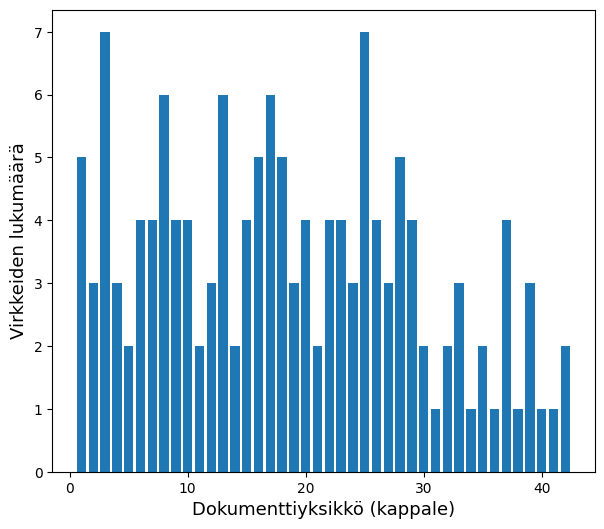

In [10]:
values = [len(splitter.split(kpl)) for kpl in kappaleet.values()]
plt.figure(figsize=(7, 6))

fig = plt.bar(np.arange(1, len(values) + 1), values)
plt.xlabel("Dokumenttiyksikkö (kappale)", size=13)
plt.ylabel("Virkkeiden lukumäärä", size=13)
plt.show()

### Luodaan lemmattu korpus
Lisäksi lemmattua sanaa varten luodaan "sanakirja", josta löytyy eräs tekstissä esiintynyt alkuperäinen sanan muoto.
Ei välttämättä toimi aivan yleisessä tapauksessa. Kuitenkin tämän notebookin osalta toimii.

Prosessin aikana merkit "-", "/" ja ":" sisältävät sanat katkeavat osiin. Esim. 1980-luku on "1980" ja "luku".

In [11]:
lemmattu_korpus = []
alkup_sana = {}

for sents in korpus:
    lemmattu = ""
    
    for word in nlp(sents).doc:
            
        # aihemallinnukseen otetaan mukaan substantiivit, adjektiivit ja organisaatioiden nimet alustavasti
        if word.is_stop == False and word.is_punct == False and word.pos_ in ["NOUN", "ORG", "ADJ"]:

            # käsitellään ilmaukset, joissa on "-"-merkki erikseen, jotta saadaan
            # CountVectorizer-olion tekemä muutos oikein lemmattuna
            if "-" in word.text:
                word_temp = word.text.split("-")

                for i, sana in enumerate(word_temp):
                    if sana != "":
                        lemma = nlp(sana).doc[0].lemma_
                        alkup_sana[lemma.lower()] = word_temp[i]
                        lemmattu += lemma.lower() + " "

            # sama kuin yllä merkin "." sisältäville ilmaisuille
            elif "." in word.text:
                word_temp = word.text.split(".")

                for i, sana in enumerate(word_temp):
                    if sana != "":
                        lemma = nlp(sana).doc[0].lemma_
                        alkup_sana[lemma.lower()] = word_temp[i]                
                        lemmattu += lemma.lower() + " "

            elif "/" in word.text:
                word_temp = word.text.split("/")

                for i, sana in enumerate(word_temp):
                    if sana != "":
                        lemma = nlp(sana).doc[0].lemma_
                        alkup_sana[lemma.lower()] = word_temp[i]                
                        lemmattu += lemma.lower() + " "
                                        
            else:
                alkup_sana[word.lemma_.lower()] = word.text
                lemmattu += word.lemma_ + " "

    if lemmattu != "": lemmattu_korpus.append(lemmattu.strip())


In [12]:
len(lemmattu_korpus)

42

In [13]:
from tmtoolkit.topicmod.tm_lda import evaluate_topic_models
from tmtoolkit.topicmod.evaluate import results_by_parameter

pip install -U scikit-learn

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
# Tekstissä esiintyy englanninkielisiä stop wordeja, jotka huomioidaan tässä.
# Lisäksi prosessin aikana tekstissä hajoaa kaksoispisteen (:) jälkeiset päätteet omiksi sanoikseen.
# Nämä päätteet valitaan omiksi lisä stop wordeiksi

omat_stop_wordit = ["the", "of", "lle", "llä", "lla", "sta", "stä", "n", "ää", "da", "ce", "cpc",  "ii", "zx", "3d"]

cv = CountVectorizer(max_df=0.8, min_df=0.04, encoding="utf-8", stop_words = omat_stop_wordit)
X = cv.fit_transform(lemmattu_korpus)

In [16]:
X.shape

(42, 117)

In [17]:
cv.get_feature_names_out()

array(['16', '1980', '1990', 'aika', 'ala', 'alue', 'alusta', 'c64',
       'dema', 'demo', 'demoja', 'demojen', 'demomusiikki',
       'demontekijöiden', 'demoparty', 'demopartyinen', 'demopartyjen',
       'demopartyt', 'demoryhmä', 'demoskene', 'demoskenen', 'demoskenki',
       'digitaalinen', 'efekti', 'elokuu', 'ensimmäisistä', 'erilainen',
       'erillinen', 'erityinen', 'graafikko', 'graafinen', 'grafiikka',
       'haaste', 'henkilö', 'ihminen', 'intro', 'jäsen', 'kansainvälinen',
       'kappale', 'kaupallinen', 'kehitys', 'kilotavun', 'kilpailu',
       'kilpailusarjo', 'kompa', 'kone', 'kortti', 'kotitietokone',
       'kulttuuri', 'käyttäjä', 'käyttö', 'laite', 'laitteisto', 'loppu',
       'luominen', 'luvu', 'luvun', 'malli', 'musiikki', 'muusikko',
       'määrä', 'nimitys', 'nykyinen', 'ohjelma', 'ohjelmallinen',
       'ohjelmisto', 'ohjelmoija', 'ohjelmoinnillinen', 'ohjelmointi',
       'osa', 'palkinto', 'parhaat', 'parhaiden', 'pc', 'pcm', 'peli',
       'perusla

Riippuen tmtoolkit-kirjaston asennuksesta metriikoita voi olla enemmänkin

In [18]:
import tmtoolkit.topicmod.tm_lda
tmtoolkit.topicmod.tm_lda.AVAILABLE_METRICS

('loglikelihood', 'cao_juan_2009', 'arun_2010', 'coherence_mimno_2011')

In [19]:
# Aihemallin evaluointifunktio
def evaluate(X, ts, te):

    const_params = {
        'n_iter': 1000,
        'random_state': 42,  # tulokset ovat toistettavissa
        'eta': 0.1,          # joskus käytetään nimitystä "beta", muistelen lukeneeni, että tämän suositellaan olevan "pieni" arvo
    }

    # iteroidaan LDA-mallia eri määrillä aiheita
    var_params = [{'n_topics': k, 'alpha': 1/k}
                for k in range(ts, te)]
            
    return evaluate_topic_models(X, varying_parameters=var_params,
                                     constant_parameters=const_params,
                                     coherence_mimno_2011_top_n=7,
                                     coherence_mimno_2011_include_prob=True,
                                     return_models=True)

In [20]:
ts = 2              # aiheita pyritään samaan vähintään 2
te = X.shape[0]     # maksimi määrä aiheille on korpukseen niputettujen virkeryppäiden määrä
ts, te

(2, 42)

In [21]:
tulokset = evaluate(X, ts, te)
eval_results_by_topics = results_by_parameter(tulokset, 'n_topics')

In [22]:
# kerätään koherenssitulokset
koherenssi = []
for i in range(len(eval_results_by_topics)):
    koherenssi.append(eval_results_by_topics[i][1]["coherence_mimno_2011"])

In [23]:
parhaan_mallin_indeksi = np.argmax(koherenssi)
paras_Mimno_LDA = eval_results_by_topics[parhaan_mallin_indeksi][1]["model"]

In [24]:
topic_nums = []

topic_results = paras_Mimno_LDA.transform(X)
for topic_dist in topic_results:
    topic_num = topic_dist.argmax()
    topic_nums.append(topic_num)
print("Aiheet:", topic_nums)
print("Aiheiden määrä:", paras_Mimno_LDA.n_topics)

Aiheet: [1, 7, 7, 5, 7, 6, 8, 1, 2, 5, 6, 2, 9, 10, 2, 4, 4, 3, 3, 3, 3, 3, 3, 1, 1, 7, 2, 10, 10, 5, 8, 9, 3, 0, 0, 6, 0, 1, 3, 8, 4, 10]
Aiheiden määrä: 11


Piirretään graafi koherenssista suhteessa aiheiden määrään

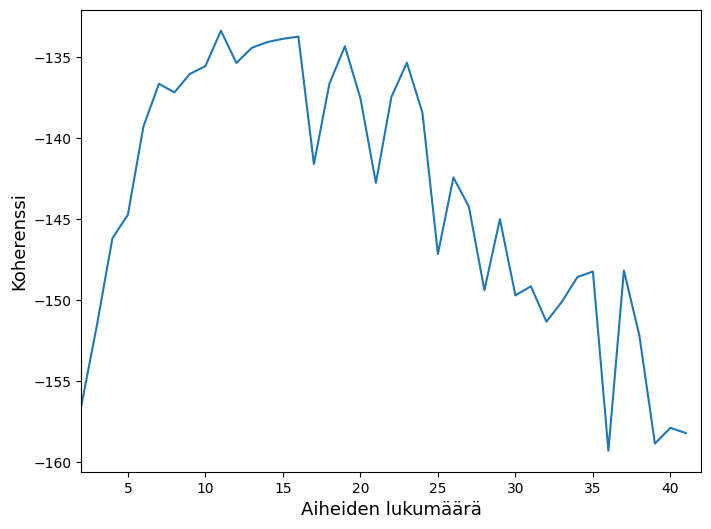

In [25]:
xs = np.arange(2,len(koherenssi)+2)

plt.figure(figsize=(8, 6))
fig = plt.plot(xs,koherenssi)
plt.xlim(2,len(koherenssi)+2)
plt.xlabel("Aiheiden lukumäärä", size=13)
plt.ylabel("Koherenssi", size=13)
plt.show()

In [26]:
# Poimitiaan kunkin aiheen aihesanat
Mimno_topic_words = [[] for i in range(paras_Mimno_LDA.n_topics)]
top_words = [[] for i in range(paras_Mimno_LDA.n_topics)]
Mimno_topics = paras_Mimno_LDA.fit(X)

index = 0
for ind, topic in enumerate(Mimno_topics.components_):
    
    if ind in topic_nums:
        Mimno_topic_words[index] = [cv.get_feature_names_out()[i]
                                   for i in topic.argsort()[-10:]]
        
        for j, word in enumerate(Mimno_topic_words[index]):
            top_words[ind].append(word)

        index = index + 1



In [27]:
aihesanat_dict = {}

# Tulostetaan aihesanat, nille haetaan "sanakirjasta" eräs alkuperäinen sanan muoto
for i in range(paras_Mimno_LDA.n_topics):
    words = top_words[i]
    aihesanat = ""
    for w in words:
        aihesanat += alkup_sana[w.lower()] + " "
    print(f"AIHE {i+1}:", aihesanat.strip())
    aihesanat_dict[i+1] = aihesanat.strip()

AIHE 1: graafikot ohjelmien parhaiden tekijöille Suomalaisia luomisesta demoryhmiä luvulla suomalaista vuonna
AIHE 2: käyttäjien alueet kaupallisten demot Varhaisimmat ensimmäisistä efektien ryhmän pelinsä musiikkia
AIHE 3: alustalta yksinkertaiseen 1990 luvun demontekijöiden demoskenen laitteiden laitteiston PC koneen
AIHE 4: henkilö useat tapa palkintoja ajasta ihmisten suuremman tuotokset demoskenen tapahtuman
AIHE 5: erityisissä Parhaat tapahtumissa vuonna määrälle teoksia kilpailuja demojen yleisön demot
AIHE 6: lopussa pelinsä tekijöille tekniikka alan 1990 toimintaan ajasta jäseniä ryhmän
AIHE 7: puolivälin mallit luvun demoskenen valtaosa PC kehityksen vuonna nykyiseen demot
AIHE 8: varhainen osa Demojen tuotokset PCM Tracker ääntä 1980 ohjelmien luvun
AIHE 9: erilaisten useammalle kilotavun jäseniä alueet saksalaisen ohjelmoinnillisten henkilö tiettyyn ryhmän
AIHE 10: ohjelmointiin useammalle tekemiseen yleistä 1990 demoskenen introissa graafinen ohjelmoijat osa
AIHE 11: malli

In [28]:
from wordcloud import WordCloud

Aihesanat graafisena sanapilvenä

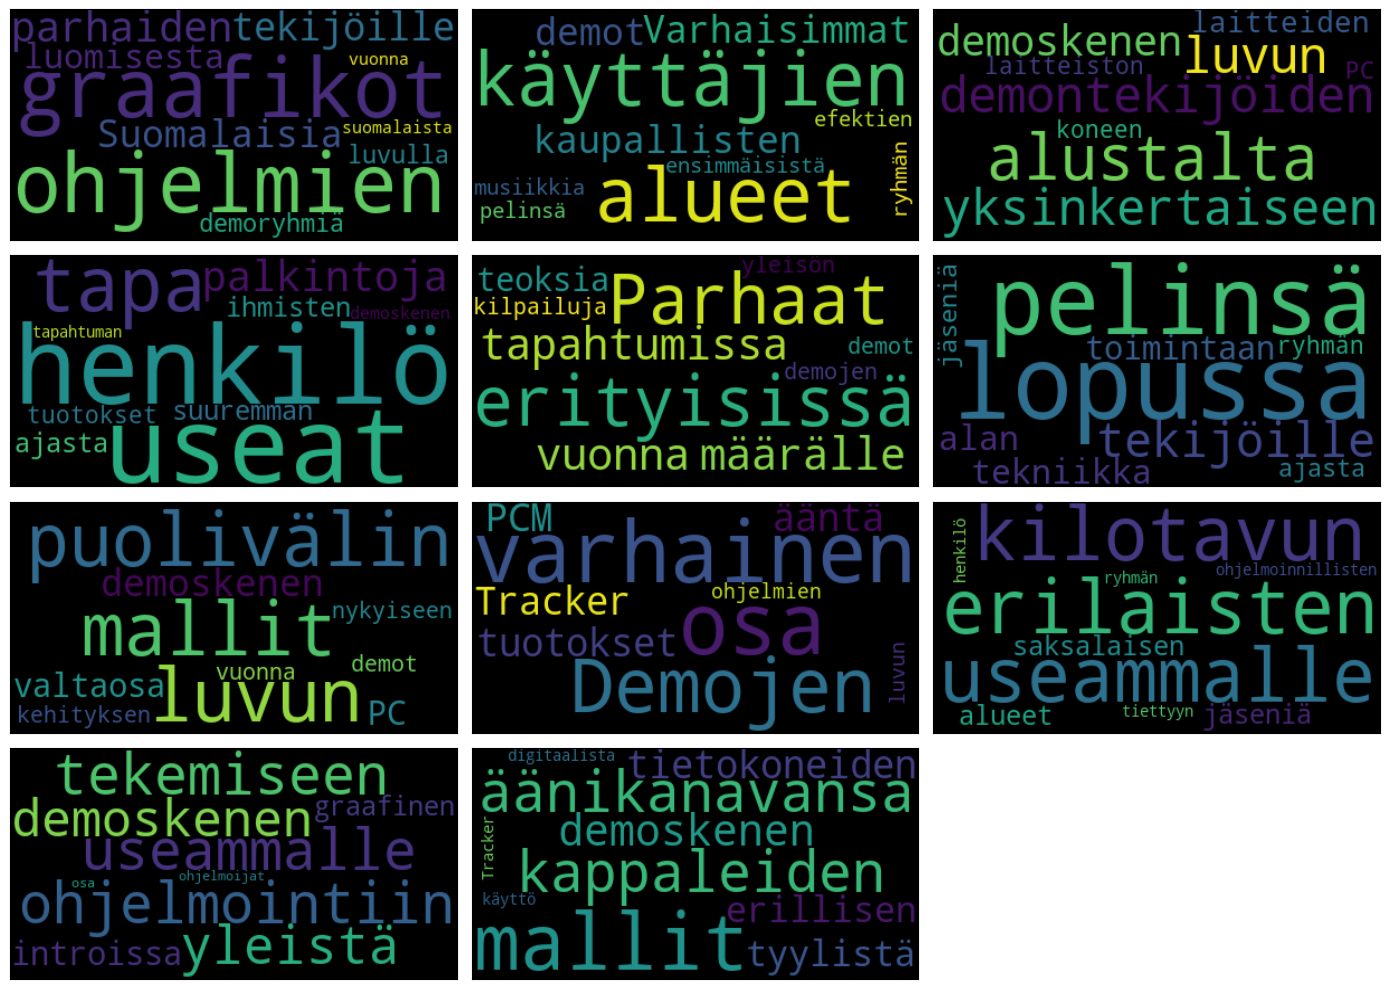

In [29]:
pilvi = []
for i, sanat in enumerate(aihesanat_dict.values()):
    wc = WordCloud().generate_from_text(sanat)
    pilvi.append(wc)

fig = plt.figure(figsize=(14, 10))
columns = 3
rows = 4
for i, img, in enumerate(pilvi):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    plt.imshow(img, interpolation="bilinear", aspect="auto")
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Demoskenen Wikipedia-sivun aihemallinnuksen aihesanat')

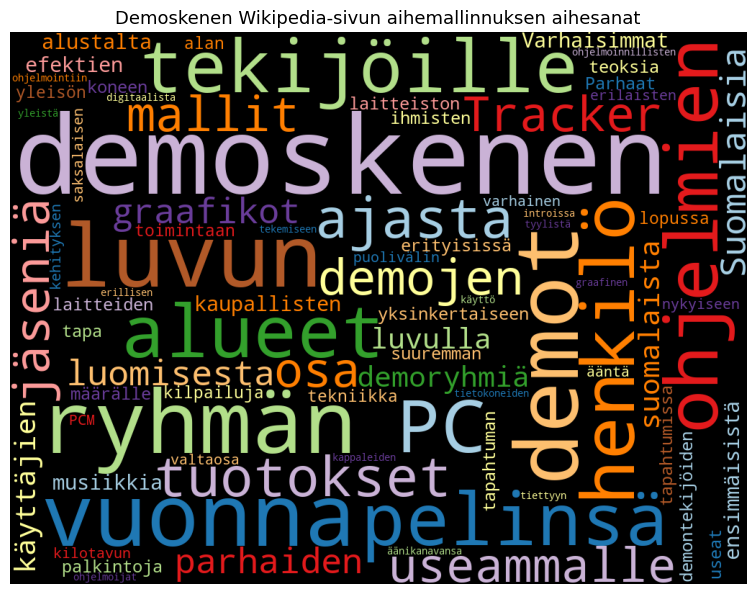

In [30]:
kaikki_aihesanat = " ".join(aihesanat_dict.values())
sanapilvi = WordCloud(width=1024, height=768, colormap='Paired').generate_from_text(kaikki_aihesanat)
plt.figure(figsize=(9.5,7.5))
plt.imshow(sanapilvi)
plt.axis('off')
plt.title("Demoskenen Wikipedia-sivun aihemallinnuksen aihesanat", fontsize=13)

Alkuperäisessä demoskeneä käsittelevässä Wikipedia-sivussa (22.8.2023) on varsinaisia sisältöä käsitteleviä sektioita 7, kun luetteloita yms. ei lasketa mukaan. Vaati paljon kokeilua, jotta aiheet saatiin suhteellisen ehyiksi kontekstiltaan. Pienimmillään yksittäinen dokumenttiyksikkö on vain 1 virke. Usein erilaisella sanojen karsinnalla ja erilaisilla parametreilla saattoi pronominien vuoksi viittaus olla konteksiltaan pielessä.

Toisaalta, aihemallinnuksen tarkoitus joskus on saada nopeasti mielikuva dokumenttien tai erillisten dokumenttien sisällöstä.

In [31]:
# Tulostetaan aihekokonaisuudet
for t in range(paras_Mimno_LDA.n_topics):
    print(f"\n=== Aihe {t+1} ===")
    for i, k in enumerate(topic_nums):
        if k == t:
            print() # tyhjä rivi osoittamaan, mistä alkaa seuraava dokumenttiyksikkö
            virkkeet = splitter.split(korpus[i])
            for virke in virkkeet:
                print(virke)


=== Aihe 1 ===

Suomessa on perinteisesti ollut paljon kansainvälisesti arvostettuja demoryhmiä, joiden ansiosta Suomi on ollut pitkään yksi merkittävimmistä demoskenemaista muiden pohjoismaiden ja Saksan ohella.

Suomalaisia ryhmiä tai kansainvälisiä ryhmiä, joissa on tai on ollut suomalainen divisioona tai suomalaisia jäseniä, ovat muun muassa Ananasmurska, Komplex, Byterapers, Kooma, Damage, Matt Current, Damones, mfx, Dekadence, Moppi Productions, Extend, Orange, Faktory, Parallax, flo, Paranoids, Future Crew, PWP, HiRMU, RNO, ISO, tAAt, Jumalauta, Tpolm, Halcyon, CNCD, Traction, wAMMA ja Kewlers.
Ulkomaalaisia demoryhmiä ovat muun muassa ACiD, Melon Dezign, ASD, Oxyron, Black Maiden, Pulse, Calodox, Ram jam, Cocoon, Rebels, Conspiracy, Sanity, Darkage, Scoopex, Dual Crew & Shining, Sunflower, Ephidrena, Surprise!Productions, Fairlight, The Black Lotus, Farbrausch, The Silents, Haujobb, Triad, Kolor ja TRSI.

Jo 1980-luvulta alkaen monet menestyneet peliohjelmoijat, -graafikot ja 

Apufunktio, joka tulostaa tietyn aiheen.
Aiheiden numneroinnin katsotaan alkavan 1:stä, joten funktiossa annetusta aiheesta vähennetään 1.

In [32]:
# Funktio, joka tulostaa tietyn aiheen
def tulosta_aihe(aihe_nro):
    aihe = ""
    aihe_nro -= 1
    for t in range(paras_Mimno_LDA.n_topics):
        for i, k in enumerate(topic_nums):
            if aihe_nro == k and k == t:
                aihe += "".join(korpus[i]) + " "
    print(aihe.strip())

In [34]:
tulosta_aihe(7)

1990-luvulle saapuessa demoskenen kehitys alkoi suuntautua kohti nykyistä malliaan. Ryhmät alkoivat keskittyä pelkästään demojen luomiseen tai perustivat erillisen jaoston niiden tuottamiseen. Tapahtumien järjestäjät alkoivat ajan myötä kieltää laittomien ohjelmien levittämisen, jolloin nykyisten demopartyjen toimintamallin voidaan katsoa alkaneeksi. Piratismin jäädessä sivualalle demoskene oli kehittynyt omaksi alakulttuurikseen. 1990-luvun puolivälin tienoilla PC-demot alkoivat muistuttaa näyttävyydeltä jo Amigan vastaavia ja seuraavana demojen kehityksenä olivat entistä monimutkaisempien 3D-mallien animoiminen, jolloin PC:n raaka laskentateho pääsi näyttämään kyntensä. Commodoren konkurssi vuonna 1994 ja siten laitealustan kehityksen päättyminen johti lopulta siihen, että PC-yhteensopivat ajoi Amigasta ohi pääkehitysalustana. Vaikka demoskene on vieläkin varsin pitkälti underground-kulttuuria ja demontekijät muodostavat edelleen valtaosan omasta yleisöstään, ovat demot vaikuttaneet 